# Ludo as a Markov Chain

The board game of <a href="https://en.wikipedia.org/wiki/Ludo_(board_game)">Ludo</a> can be modeled as a first order [Markov Chain](https://en.wikipedia.org/wiki/Markov_chain) as it is "memoryless" i.e the next state only depends on the current state. Of course, we make some (big) assumptions to make it so.

(Note: Pretty much all of this is based on the [Simulating Chutes and Ladders](https://jakevdp.github.io/blog/2017/12/18/simulating-chutes-and-ladders/) post by *Jake VanderPlas*.
In fact, it's a way simpler treatment).

Anyway, we'll make the following assumptions:

- There's one player. Simplifies things greatly.
- There's only one piece. (I'm really lazy :P)
- Rolling a *One* moves the piece out of the yard onto the track. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

In [2]:
rcParams['figure.figsize'] = 6, 6

## The transition matrix

A Markov Process can be entirely described using a transition matrix $S$ x $S$ transition matrix $M$ where $S$ is the number of states.

Let $M_{ij}$ denote the transition probability from state $i$ to $j$ i.e row $i$ of $M$ is the transition probability when in state $i$.

<img src="assets/Ludo_board.png" alt="LudoBoard" width="200">

Here, we have 58 states (56 cells on the track and one each for the yard and the finish state).

When in the first state ($S_{0}$, the yard), the probability of rolling a *One*, $p(1)$ is the transition probability of moving to the track ($S_{1}$). $1 - p(1)$ is the probability of staying in the yard.

For most of the track, we are always moving forward. How many cells forward is of course determined by the roll of the die. Towards the end, the piece can "bounce back" if we exceed the exact value required to reach home. We need to account for that.

Finally, after we're at the last state (home), we stay there forever...

In [3]:
def create_transition_matrix(die_prob=None):
    # If the die's probability isn't provided, assume a fair die.
    if die_prob is None:
        die_prob = [1/6] * 6
    elif not np.isclose(np.sum(die_prob), 1.0):
        print(die_prob)
        raise ValueError("Die Probability doesn't sum to 1.")
        
    first_state = 0
    last_state = 57
    
    # Initialize everything with zeros.
    mat = np.zeros((58, 58))

    # First state is the yard
    mat[first_state][1] = die_prob[0]
    mat[first_state][0] = 1 - die_prob[0]
    
    # For every other state apart from the last.
    for s in range(1, last_state):
        # For every possible die roll
        for j in range(6):
            next_state = s + j + 1
            # Bounce back if necessary
            if next_state > last_state:
                next_state = last_state - (next_state - last_state)
            mat[s][next_state] += die_prob[j]
    
    # Stay at the last state
    mat[last_state][last_state] = 1.0
    return mat

Here's the matrix.

In [4]:
mat = create_transition_matrix()

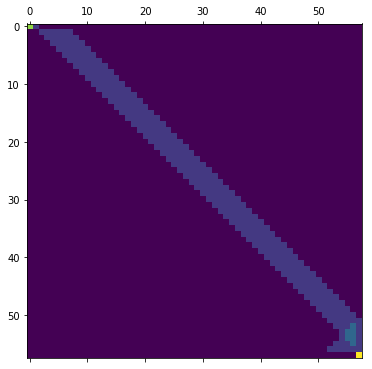

In [5]:
plt.matshow(mat)
plt.grid(False)
plt.show()

Nothing fancy.

The top left (green) corner is the *waiting-for-the-one* zone. Can be frustrating. 

Most of the matrix is pretty bland. Towards the bottom right, we finally have some activity due to the chance of the piece "bouncing" back. 

Finally, the bottomest right is home. The game is over. 

## Getting the die rolling

We need to define a state vector denoting the probability of being in any of the states. We start off with a vector whose first element is 1.0 and all others are zeros. 

We can then step through the game by repeatedly left multiplying the state vector with the transition matrix to get the new state vector. For n moves, this amounts to.

$$
w_{n} = w_{0}\ M^{n}
$$

In [6]:
def compute_probability(mat, n):
    w = np.zeros(len(mat))
    w[0] = 1.0
    final_w = np.dot(w, np.linalg.matrix_power(mat, n))
    return final_w

Let's simulate 80 moves. The probability of the last element of the state vector is the probability of the home state (i.e the end of the game).

In [7]:
moves = np.arange(1, 81)
probs = np.array([compute_probability(mat, i)[-1] for i in moves])

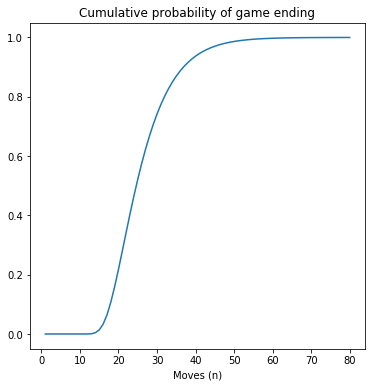

In [8]:
plt.plot(moves, probs)
plt.title('Cumulative probability of game ending')
plt.xlabel('Moves (n)')
plt.show()

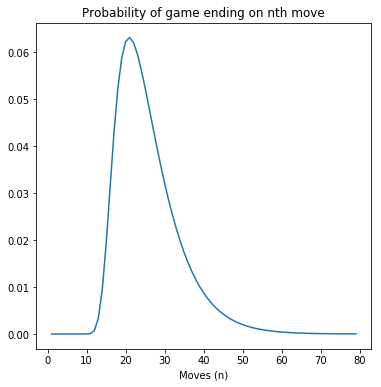

In [9]:
plt.plot(np.arange(1, 80), np.diff(probs))
plt.title('Probability of game ending on nth move')
plt.xlabel('Moves (n)')
plt.show()

## Some statistics

###  Quickest Finish

In [10]:
moves[probs > 0][0]

11

Given our construct of the game this is obvious. One move to get on the track and then 10 moves to cover the next 57 steps (say 9 sixes and a three). 

### Mean

In [11]:
np.dot(np.diff(probs), np.arange(1, len(probs)))

25.753278735611076

On average, the game ends in ~26 moves.

### Median

In [12]:
np.searchsorted(probs, 0.5)

24

So, approximately 50% of the games will be finished in fewer than 24 moves, 50% will be finished in more than 24 moves.

### Really unlucky

In [13]:
moves[probs > 0.99][0]

52

52 moves in and still not finished? Really unlucky. 

## Gifing it up

(Again, this section is heavily ~~copied~~ adapted from Jake's post).

First, we need a method to reshape our probability to a matrix to be overlaid over the image. Not trivial.

Could do manual mappings but we can do better. Specifically, for the cells apart from the first section and the final "runway", we will map to an inverted U strip and then rotate appropriately, assuming the center of the board is (0, 0). We'll then map that result back to the actual coordinate system with origin at the top left corner.

In [14]:
def reshape_probabilities(probs):
    board_probs = np.zeros((15, 15))
    
    # Yard
    board_probs[0:6, 0:6] = probs[0]
    
    # Opening Track
    for i in range(1, 6):
        board_probs[6][i] = probs[i]
        
    # Tracks before final runway
    for i in range(6, 51):
        adjusted = i - 6
        rotation = int(adjusted / 13)
        rem_index = adjusted % 13
        
        # Quadrant index
        x = rem_index - 6
        if x != 0:
            x = x / abs(x)
        y = 7 + abs(x) - abs(rem_index - 6)
        
        location = np.array([x, y])
        
        # Rotate quadrant index
        clockwise_rotation = np.array([[0, -1], [1, 0]])
        for r in range(rotation):
            location = np.dot(location, clockwise_rotation)
        
        # Translate to be centered at top left     
        final_x = int(location[1] * -1.0 + 7)
        final_y = int(location[0] + 7)
        board_probs[final_x][final_y] = probs[i]
        
    # Final Runway and home
    for i in range(51, 58):
        board_probs[7][i - 51] = probs[i]
        
    return board_probs

In [15]:
reshape_probabilities([1.0] * 58)

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.

In [16]:
from matplotlib import colors

# Make a blue colorbar with increasing opacity
c = np.zeros((100, 4))
c[:, -1] = np.linspace(0, 1, 100)  # transparency gradient
c[:, 2] = 0.5  # make the map dark blue
TransparencyMap = colors.ListedColormap(c)        

def show_board(mat, turn):
    fig, ax = plt.subplots()
    board = plt.imread('assets/Ludo_board_cropped.png')
    
    # Compute & reshape the probability vector
    probs = compute_probability(mat, turn)
    probs = reshape_probabilities(probs)
    
    # Show result over the image of the board
    ax.imshow(board, alpha=0.8)
    im = ax.imshow(probs, extent=[0, 720, 720, 0], 
                   norm=colors.LogNorm(vmin=1E-3, vmax=1), 
                   cmap=TransparencyMap)
    fig.colorbar(im, ax=ax, label='Fraction of games')
    ax.axis('off')
    ax.set_title(f"Turn {turn}")
    
    return fig

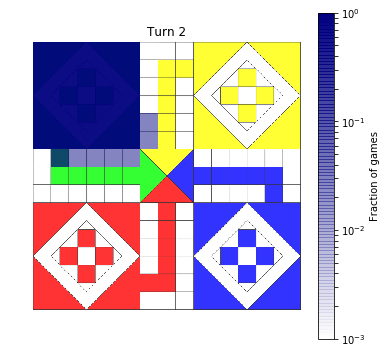

In [17]:
show_board(mat, 2)
plt.show()

Let's create a gif!

In [18]:
import imageio
from io import BytesIO

def make_gif(figures, filename, fps=10, **kwargs):
    images = []
    for fig in figures:
        output = BytesIO()
        fig.savefig(output)
        plt.close(fig)  # close figure when we're finished to prevent matplotlib warnings
        output.seek(0)
        images.append(imageio.imread(output))
    imageio.mimsave(filename, images, fps=fps, **kwargs)

In [19]:
frames = [*range(50), *range(50, 101, 10)]
sims = (show_board(mat, i) for i in frames)

duration = np.zeros(len(frames))
duration[:8] = 0.5
duration[44:50]= 0.5
duration[-1] = 1.0

make_gif(sims, 'assets/Ludo-sim.gif', fps=8, duration=list(duration))

Here's how it ends up.

![Sim](assets/Ludo-sim.gif)

## Changing the die

Just for the heck of it, let's tamper with our die to change the probability of rolling a *One*.

In [20]:
# Rolling a one has 0.5 prob, others have only 0.1 each.
mat = create_transition_matrix(die_prob=[5.0 / 10.0] + [1.0 / 10.0] * 5)

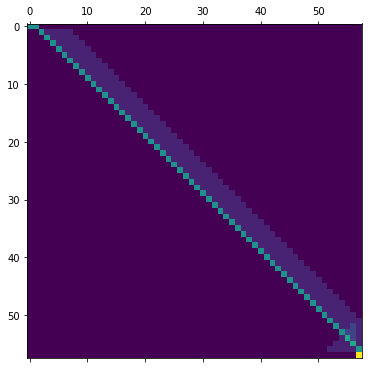

In [21]:
plt.matshow(mat)

In [22]:
probs = np.array([compute_probability(mat, i)[-1] for i in np.arange(1, 81)])

In [23]:
print('Mean: ', np.dot(np.diff(probs), np.arange(1, len(probs))))
print('Median: ', np.searchsorted(probs, 0.5))

Mean:  26.438432527301043
Median:  26


Increasing the probability of rolling a *One* to 0.5 actually increased the average length of the game i.e it was detrimental. There's a tradeoff here. Getting a one quickly gets us out on to the track quickly but then from there getting *One*s more often slows our pace.

As our final act, let's visualize that tradeoff.

In [24]:
one_probs = np.arange(0.05, 1.0, 0.05)
means = []
medians = []
for one_prob in one_probs:
    die_prob = [one_prob] + [(1.0 - one_prob) / 5] * 5
    mat = create_transition_matrix(die_prob=die_prob)
    moves = np.arange(1, 201)
    probs = np.array([compute_probability(mat, i)[-1] for i in moves])
    means.append(np.dot(np.diff(probs), np.arange(1, len(probs))))
    medians.append(np.searchsorted(probs, 0.5))

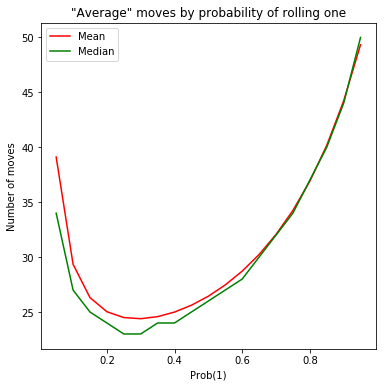

In [25]:
plt.plot(one_probs, means, color='r', label='Mean')
plt.plot(one_probs, medians, color='g', label='Median')
plt.title('"Average" moves by probability of rolling one')
plt.xlabel('Prob(1)')
plt.ylabel('Number of moves')
plt.legend()
plt.show()

Looks like if we ever find ourselves in this kind of a ludo game with the ability to tamper with the die, we should make the probability of *One* to be ~0.3. Good to know! 

## Final Words

This could probably be extended to the multiple pieces case or even the multiple player case if we place some constraints to retain the Markov property. But the number of states would probably be intractable enough to warrant running direct simulations instead. 

Anyway, this was fun.